In [1]:
import torch
import numpy as np
from mytest.diffusion import EuclideanDiffuser, IGSO3, Diffuser

# 创建单个蛋白质结构 (L, 3, 3) - N, CA, C coordinates
L = 100  # 序列长度
xyz = torch.randn(3,L, 3, 3)  # 随机坐标作为示例

# 初始化Euclidean扩散器
eucl_diffuser = EuclideanDiffuser(
    T=200,           # 扩散步数
    b_0=0.01,        # 初始方差
    b_T=0.07,        # 最终方差
    schedule_type="linear"
)

# 扩散坐标
diffused_coords, deltas = eucl_diffuser.diffuse_translations(xyz)
print(f"Original shape: {xyz.shape}")
print(f"Diffused coords shape: {diffused_coords.shape}")  # (T, L, 3, 3)
print(f"Deltas shape: {deltas.shape}")  # (T, L, 3)

/WORK/PUBLIC/lulei_work/xjt/Protein_design/RFdiffusion/rfdiffusion/util.py:253: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  Z = torch.cross(Xn, Yn)
/home/fit/lulei/WORK/.conda/envs/SE3nv/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:104: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=th.float16)
/home/fit/lulei/WORK/.conda/envs/SE3nv/lib/python3.9/site-packages/dgl/backend/pytorch/sparse.py:128: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dZ):
/home/fit/lulei/WORK/.conda/envs/SE3n

tensor([[[    -0.8016,     -2.0330,     -1.0970],
         [    -1.3436,      0.5398,     -1.0506],
         [    -0.8974,     -1.3532,      0.8607],
         [     0.2387,      0.0211,     -0.9312],
         [    -0.2493,     -1.0013,     -1.2025],
         [    -0.7637,      0.2492,     -0.4612],
         [     0.5237,     -0.8570,      0.8650],
         [    -0.7211,      0.0515,     -0.5458],
         [     0.1950,      0.9584,      2.0724],
         [     0.6503,      0.9783,     -0.0026],
         [     0.2538,      0.6076,     -0.0971],
         [     1.8886,      1.7140,      0.3006],
         [     0.3345,     -0.9377,      0.4778],
         [     0.1641,      0.5299,     -0.3155],
         [     2.3083,      0.9736,      0.7754],
         [     1.7151,      0.5783,      0.6507],
         [    -0.1689,     -1.0998,      1.6349],
         [     1.7038,     -0.1584,      0.2049],
         [    -0.0739,     -0.4930,     -0.5865],
         [     0.7880,     -0.5661,     -0.6288],


In [3]:
# 创建批处理数据 (B, L, 3, 3)
B = 3 # batch size
L = 5
xyz_batch = torch.zeros(B, L, 3, 3)

# 创建扩散掩码 - True表示不扩散，False表示扩散
diffusion_mask = torch.zeros(B, L, dtype=bool)
diffusion_mask[:, :1] = True  # 前10个残基不扩散

# 批处理扩散
diffused_batch, deltas_batch = eucl_diffuser.diffuse_translations(
    xyz_batch, 
    diffusion_mask=diffusion_mask
)
torch.set_printoptions(profile="full")

print(f"Batch diffused shape: {diffused_batch}")  # (B, T, L, 3, 3)
print(f"Batch deltas shape: {deltas_batch}")  # (B, T, L, 3)
torch.set_printoptions(profile="default")

sampled_crds tensor([[[    -0.0260,      0.0348,      0.0623],
         [     0.0799,      0.0411,      0.1298],
         [    -0.0860,     -0.1262,      0.1059],
         [    -0.0933,      0.2183,      0.0349],
         [     0.0003,     -0.1019,      0.0132]],

        [[    -0.1778,     -0.0576,     -0.0587],
         [     0.0197,     -0.1664,      0.0514],
         [    -0.0675,     -0.0691,      0.0125],
         [    -0.0219,      0.0377,      0.0378],
         [     0.1091,      0.0766,     -0.0152]],

        [[     0.0035,      0.0194,     -0.0647],
         [     0.1298,     -0.0726,      0.1080],
         [    -0.0361,     -0.0390,      0.1031],
         [     0.3155,      0.0317,      0.0178],
         [    -0.0855,     -0.1580,      0.0221]]])
sampled_crds tensor([[[ 0.1720, -0.0785, -0.1171],
         [ 0.0235,  0.2628,  0.1073],
         [-0.1075,  0.0422,  0.3123],
         [-0.0556,  0.4368,  0.0875],
         [ 0.0626, -0.0169,  0.0152]],

        [[ 0.0623, -0.0677

In [7]:
import torch
import numpy as np
import logging
import os
from mytest.diffusion import IGSO3

# 设置日志
logging.basicConfig(level=logging.INFO)

# 1. 基本IGSO3初始化和单结构测试
print("=== 1. 基本IGSO3初始化和单结构测试 ===")

# 创建cache目录
os.makedirs("./cache", exist_ok=True)

# 初始化IGSO3扩散器
so3_diffuser = IGSO3(
    T=100,  # 使用较小的T进行快速测试
    min_sigma=0.1,
    max_sigma=1.5,
    min_b=0.01,
    max_b=0.07,
    cache_dir="./cache",
    schedule="linear",
    L=1000  # 截断级别
)

print("\n=== 2. 批处理结构测试 ===")

# 创建批处理数据 (B, L, 3, 3)
B = 10
L = 15
xyz_batch = torch.randn(B, L, 3, 3)

print(f"批处理输入形状: {xyz_batch.shape}")

# 批处理旋转扩散
diffused_batch, R_batch = so3_diffuser.diffuse_frames(
    xyz_batch,
    t_list=None,
    diffusion_mask=None
)

print(f"批处理扩散后坐标形状: {diffused_batch}")  # 应该是 (B, L, T, 3, 3)
print(f"批处理旋转矩阵形状: {R_batch.shape}")  # 应该是 (B, L, T, 3, 3)

INFO:mytest.diffusion:Using cached IGSO3.


=== 1. 基本IGSO3初始化和单结构测试 ===

=== 2. 批处理结构测试 ===
批处理输入形状: torch.Size([10, 15, 3, 3])
批处理扩散后坐标形状: tensor([[[[[-2.3190e+00, -2.7616e-02, -2.6874e-01],
           [ 1.2066e-01, -1.6045e-01,  1.1138e+00],
           [ 9.0444e-01, -5.9754e-01, -1.8695e+00]],

          [[-2.3683e+00,  2.7061e-01, -1.1107e-01],
           [ 1.2066e-01, -1.6045e-01,  1.1138e+00],
           [ 5.9911e-01, -8.9488e-01, -1.8758e+00]],

          [[-2.3434e+00, -5.1169e-01, -1.8475e-01],
           [ 1.2066e-01, -1.6045e-01,  1.1138e+00],
           [ 8.7924e-01, -1.3556e+00, -1.6614e+00]],

          ...,

          [[-2.4094e+00, -4.6878e-01, -6.3002e-02],
           [ 1.2066e-01, -1.6045e-01,  1.1138e+00],
           [ 7.2095e-01, -1.3884e+00, -1.6858e+00]],

          [[-2.4904e+00,  4.2908e-01,  2.6767e-01],
           [ 1.2066e-01, -1.6045e-01,  1.1138e+00],
           [ 3.0053e-01, -1.7332e-01, -1.9964e+00]],

          [[-2.1956e+00, -2.5236e-01, -4.6968e-01],
           [ 1.2066e-01, -1.6045e-01,  1.1138e

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np

# 可视化旋转矩阵的方法
def visualize_rotation_matrices(R_frames, residue_idx=0, time_steps=None, method='euler_angles'):
    """
    可视化旋转矩阵
    
    Args:
        R_frames: (L, T, 3, 3) 旋转矩阵 (torch.Tensor or numpy.ndarray)
        residue_idx: 选择哪个残基进行可视化
        time_steps: 选择哪些时间步，None表示所有
        method: 可视化方法 ['euler_angles', 'axis_angle', 'coordinate_frame', 'trajectory']
    """
    # 确保输入是torch tensor
    if isinstance(R_frames, np.ndarray):
        R_frames = torch.from_numpy(R_frames).float()
    
    if time_steps is None:
        time_steps = list(range(R_frames.shape[1]))
    
    # 选择指定时间步的数据
    R_selected = R_frames[residue_idx]  # (T, 3, 3)
    R_selected = R_selected[time_steps]  # (T_selected, 3, 3)
    
    if method == 'euler_angles':
        # 方法1：欧拉角可视化
        euler_angles = rotation_matrix_to_euler_angles(R_selected)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        angles_names = ['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']
        
        for i, (ax, name) in enumerate(zip(axes, angles_names)):
            ax.plot(time_steps, euler_angles[:, i], 'o-', linewidth=2, markersize=4)
            ax.set_xlabel('Time Step')
            ax.set_ylabel(f'{name} (radians)')
            ax.set_title(f'{name} Evolution')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle(f'Euler Angles Evolution for Residue {residue_idx}', y=1.02)
        plt.show()
    
    elif method == 'axis_angle':
        # 方法2：轴角表示可视化
        axis_angles = rotation_matrix_to_axis_angle(R_selected)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # 旋转轴方向
        ax1.plot(time_steps, axis_angles[:, 0], 'r-', label='X axis', linewidth=2)
        ax1.plot(time_steps, axis_angles[:, 1], 'g-', label='Y axis', linewidth=2)
        ax1.plot(time_steps, axis_angles[:, 2], 'b-', label='Z axis', linewidth=2)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Rotation Axis Components')
        ax1.set_title('Rotation Axis Direction')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 旋转角度
        angles = np.linalg.norm(axis_angles, axis=1)
        ax2.plot(time_steps, angles, 'purple', linewidth=2, marker='o', markersize=4)
        ax2.set_xlabel('Time Step')
        ax2.set_ylabel('Rotation Angle (radians)')
        ax2.set_title('Rotation Angle Magnitude')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle(f'Axis-Angle Representation for Residue {residue_idx}', y=1.02)
        plt.show()
    
    elif method == 'coordinate_frame':
        # 方法3：坐标系可视化
        fig = plt.figure(figsize=(12, 8))
        
        # 选择几个时间步进行可视化
        selected_indices = list(range(0, len(time_steps), max(1, len(time_steps)//6)))  # 最多6个时间步
        
        for i, idx in enumerate(selected_indices):
            if i >= 6:  # 最多显示6个子图
                break
            ax = fig.add_subplot(2, 3, i+1, projection='3d')
            
            R = R_selected[idx]  # (3, 3)
            
            # 原始坐标系（单位向量）
            origin = np.array([0, 0, 0])
            x_axis = R[:, 0].numpy()  # 第一列是x轴方向
            y_axis = R[:, 1].numpy()  # 第二列是y轴方向
            z_axis = R[:, 2].numpy()  # 第三列是z轴方向
            
            # 绘制坐标轴
            ax.quiver(origin[0], origin[1], origin[2], 
                     x_axis[0], x_axis[1], x_axis[2], 
                     color='red', arrow_length_ratio=0.1, linewidth=3, label='X')
            ax.quiver(origin[0], origin[1], origin[2], 
                     y_axis[0], y_axis[1], y_axis[2], 
                     color='green', arrow_length_ratio=0.1, linewidth=3, label='Y')
            ax.quiver(origin[0], origin[1], origin[2], 
                     z_axis[0], z_axis[1], z_axis[2], 
                     color='blue', arrow_length_ratio=0.1, linewidth=3, label='Z')
            
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])
            ax.set_title(f'Time Step {time_steps[idx]}')
            ax.legend()
        
        plt.tight_layout()
        plt.suptitle(f'Coordinate Frame Evolution for Residue {residue_idx}', y=0.95)
        plt.show()
    
    elif method == 'trajectory':
        # 方法4：旋转轨迹可视化
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 跟踪一个固定向量的旋转轨迹
        fixed_vector = torch.tensor([1.0, 0.0, 0.0])  # X轴方向
        
        trajectory = []
        for t_idx in range(len(time_steps)):
            R = R_selected[t_idx]
            rotated_vector = torch.matmul(R, fixed_vector)
            trajectory.append(rotated_vector.numpy())
        
        trajectory = np.array(trajectory)  # (T, 3)
        
        # 绘制轨迹
        ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
                'b-', linewidth=2, alpha=0.7)
        
        # 标记起点和终点
        ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], 
                  color='green', s=100, label=f'Start (t={time_steps[0]})')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2], 
                  color='red', s=100, label=f'End (t={time_steps[-1]})')
        
        # 绘制单位球面作为参考
        u = np.linspace(0, 2 * np.pi, 50)
        v = np.linspace(0, np.pi, 50)
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Rotation Trajectory for Vector [1,0,0] - Residue {residue_idx}')
        ax.legend()
        
        plt.show()

def rotation_matrix_to_euler_angles(R):
    """将旋转矩阵转换为欧拉角（ZYX顺序）"""
    # 处理输入类型
    if isinstance(R, np.ndarray):
        R = torch.from_numpy(R).float()
    
    if R.dim() == 3:  # (T, 3, 3)
        euler_angles = []
        for i in range(R.shape[0]):
            r = R[i]
            # ZYX欧拉角
            sy = torch.sqrt(r[0, 0] ** 2 + r[1, 0] ** 2)
            singular = sy < 1e-6
            
            if not singular:
                x = torch.atan2(r[2, 1], r[2, 2])
                y = torch.atan2(-r[2, 0], sy)
                z = torch.atan2(r[1, 0], r[0, 0])
            else:
                x = torch.atan2(-r[1, 2], r[1, 1])
                y = torch.atan2(-r[2, 0], sy)
                z = 0
            
            euler_angles.append([x.item(), y.item(), z.item()])
        
        return np.array(euler_angles)

def rotation_matrix_to_axis_angle(R):
    """将旋转矩阵转换为轴角表示"""
    # 处理输入类型
    if isinstance(R, np.ndarray):
        R = torch.from_numpy(R).float()
    
    if R.dim() == 3:  # (T, 3, 3)
        axis_angles = []
        for i in range(R.shape[0]):
            r = R[i]
            
            # 计算旋转角度
            trace = torch.trace(r)
            angle = torch.acos(torch.clamp((trace - 1) / 2, -1, 1))
            
            if torch.abs(angle) < 1e-6:
                # 很小的旋转
                axis_angle = torch.zeros(3)
            elif torch.abs(angle - np.pi) < 1e-6:
                # 180度旋转的特殊情况
                # 找到最大的对角元素
                i_max = torch.argmax(torch.diag(r))
                axis = torch.zeros(3)
                axis[i_max] = torch.sqrt((r[i_max, i_max] + 1) / 2)
                for j in range(3):
                    if j != i_max:
                        axis[j] = r[i_max, j] / (2 * axis[i_max])
                axis_angle = angle * axis
            else:
                # 一般情况
                axis = torch.tensor([
                    r[2, 1] - r[1, 2],
                    r[0, 2] - r[2, 0], 
                    r[1, 0] - r[0, 1]
                ]) / (2 * torch.sin(angle))
                axis_angle = angle * axis
            
            axis_angles.append(axis_angle.numpy())
        
        return np.array(axis_angles)

# 使用示例
print("=== 可视化旋转矩阵 ===")

# 从R_batch中选择第一个batch的数据进行可视化
# R_batch shape: (B, L, T, 3, 3) -> 选择第0个batch: (L, T, 3, 3)
batch_to_visualize = 4
R_frames = R_batch[batch_to_visualize]  # (L, T, 3, 3)

print(f"R_batch原始形状: {R_batch.shape}")
print(f"选择的batch {batch_to_visualize}形状: {R_frames.shape}")

# 选择要可视化的参数
residue_to_visualize = 7 # 第一个残基
time_steps_to_show = list(range(0, so3_diffuser.T, 1))  # 每10步取一个

# 1. 欧拉角可视化
print(f"1. 欧拉角演化 - Batch {batch_to_visualize}, Residue {residue_to_visualize}")
visualize_rotation_matrices(R_frames, residue_to_visualize, time_steps_to_show, 'euler_angles')

# 2. 轴角表示可视化
print(f"2. 轴角表示 - Batch {batch_to_visualize}, Residue {residue_to_visualize}")
visualize_rotation_matrices(R_frames, residue_to_visualize, time_steps_to_show, 'axis_angle')

# 3. 坐标系可视化
print(f"3. 坐标系演化 - Batch {batch_to_visualize}, Residue {residue_to_visualize}")
visualize_rotation_matrices(R_frames, residue_to_visualize, time_steps_to_show, 'coordinate_frame')

# 4. 旋转轨迹可视化
print(f"4. 旋转轨迹 - Batch {batch_to_visualize}, Residue {residue_to_visualize}")
visualize_rotation_matrices(R_frames, residue_to_visualize, time_steps_to_show, 'trajectory')

Successful diffuser __init__
=== 诊断信息 ===
diffused_batch shape: torch.Size([10, 8, 50, 27, 3])
clean_batch shape: torch.Size([10, 50, 3, 3])
t_list: [1, 6, 11, 16, 21, 26, 31, 36]
diffused coords range: [-2.651718, 2.369241]
clean coords range: [0.000000, 0.000000]
平均时间步变化: 0.024099
=== 1. 批次独立性分析 ===
使用指定的时间步: [1, 6, 11, 16, 21, 26, 31, 36]
批次数量: 10, 时间步数: 8
diffused_batch shape: torch.Size([10, 8, 50, 27, 3])
clean_batch shape: torch.Size([10, 50, 3, 3])
扩散坐标范围: [-0.9272, 1.0806]
原始坐标范围: [0.0000, 0.0000]
平均时间步变化: 0.024099
RMSD随时间变化: [0.09646879881620407, 0.254727303981781, 0.34678784012794495, 0.4211122393608093, 0.4980216324329376, 0.5671308040618896, 0.6229843497276306, 0.6676771640777588]


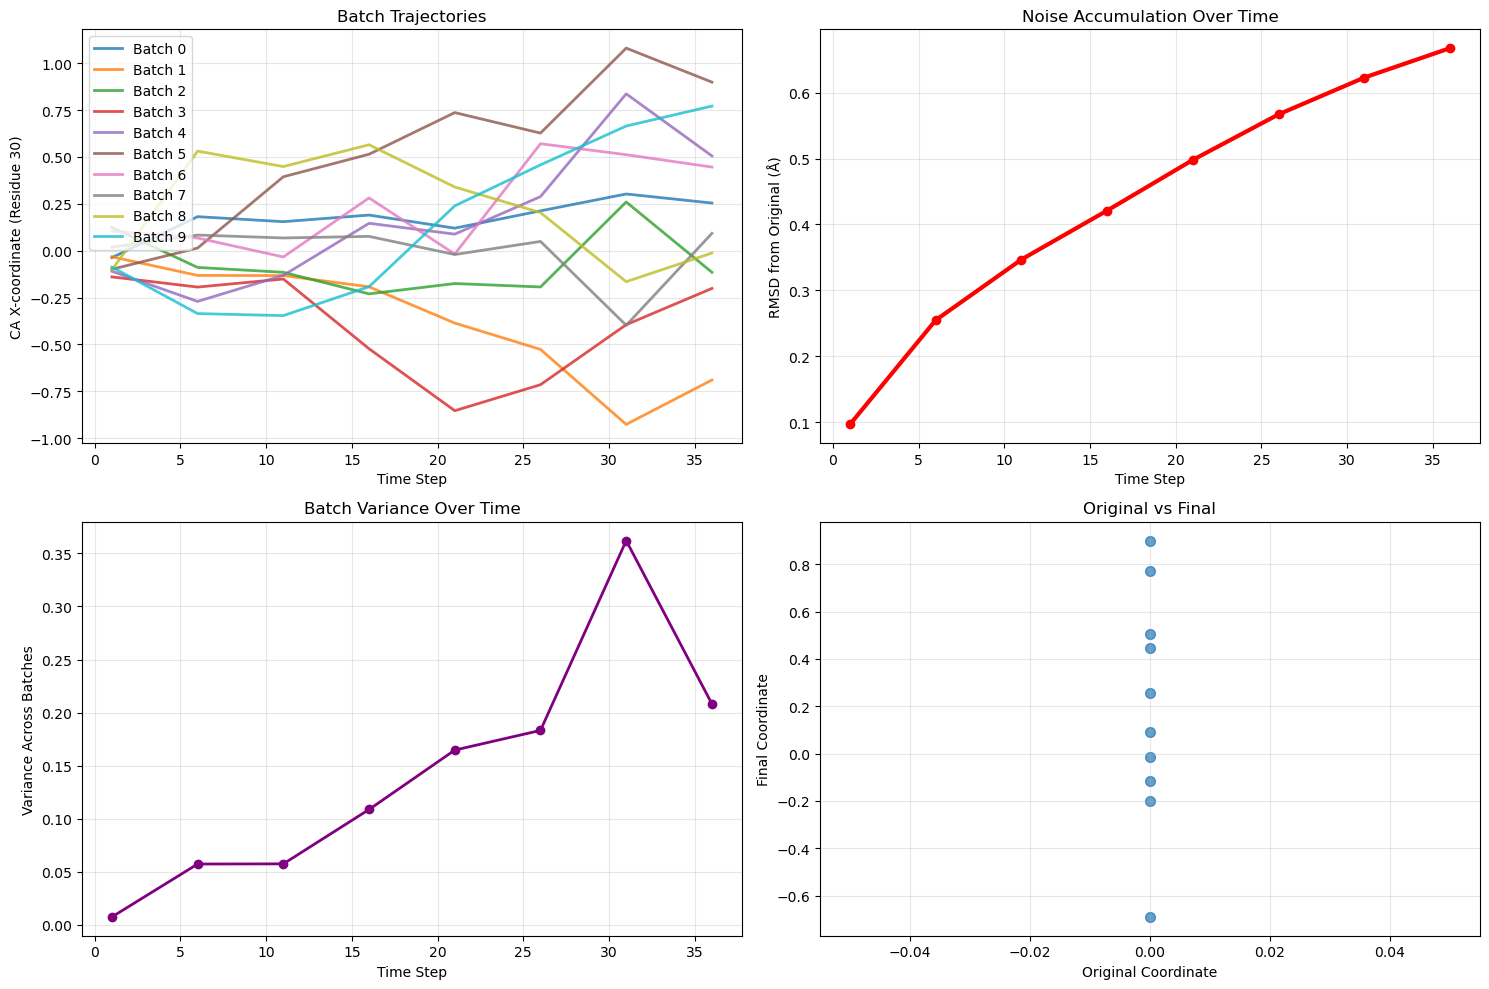

In [2]:
# 修复可视化函数中的类型转换问题

import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import torch
import numpy as np
from mytest.diffusion import EuclideanDiffuser, IGSO3, Diffuser

def visualize_diffuser_batch_results_fixed(diffuser, diffused_batch, clean_batch, t_list=None):
    """
    修复版本的可视化函数
    """
    print("=== 1. 批次独立性分析 ===")
    
    # 检查实际的时间步数
    batch_size, n_timesteps = diffused_batch.shape[0], diffused_batch.shape[1]
    
    # 如果提供了t_list，使用实际的时间步索引
    if t_list is not None:
        actual_timesteps = t_list
        print(f"使用指定的时间步: {t_list}")
    else:
        actual_timesteps = list(range(1, n_timesteps + 1))
    
    print(f"批次数量: {batch_size}, 时间步数: {n_timesteps}")
    print(f"diffused_batch shape: {diffused_batch.shape}")
    print(f"clean_batch shape: {clean_batch.shape}")
    
    # 选择分析参数
    ca_atom_idx = 1  # CA原子索引
    coord_idx = 0    # x坐标
    residue_idx = 30  # 选择第30个残基
    
    # 检查数据范围
    diffused_coords = diffused_batch[:, :, residue_idx, ca_atom_idx, coord_idx]
    clean_coords = clean_batch[:, residue_idx, ca_atom_idx, coord_idx]
    
    print(f"扩散坐标范围: [{diffused_coords.min():.4f}, {diffused_coords.max():.4f}]")
    print(f"原始坐标范围: [{clean_coords.min():.4f}, {clean_coords.max():.4f}]")
    
    # 计算时间步间的差异
    if n_timesteps > 1:
        coord_changes = []
        for t in range(1, n_timesteps):
            change = torch.abs(diffused_batch[:, t] - diffused_batch[:, t-1]).mean()
            coord_changes.append(change.item())
        print(f"平均时间步变化: {np.mean(coord_changes):.6f}")
    
    # 计算相对于原始坐标的RMSD
    rmsd_values = []
    for t in range(n_timesteps):
        diff = diffused_batch[:, t, :, ca_atom_idx, :] - clean_batch[:, :, ca_atom_idx, :]
        rmsd = torch.sqrt(torch.mean(diff**2))
        rmsd_values.append(rmsd.item())
    
    print(f"RMSD随时间变化: {rmsd_values}")
    
    # 绘图
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 时间轨迹图
    ax1 = axes[0, 0]
    trajectories = diffused_coords.detach().cpu().numpy()
    colors = plt.cm.tab10(np.linspace(0, 1, min(batch_size, 10)))
    
    for batch_idx in range(min(batch_size, 10)):  # 最多显示10个batch
        ax1.plot(actual_timesteps, trajectories[batch_idx], 
                color=colors[batch_idx], linewidth=2, 
                label=f'Batch {batch_idx}', alpha=0.8)
    
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel(f'CA X-coordinate (Residue {residue_idx})')
    ax1.set_title('Batch Trajectories')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. RMSD随时间变化
    ax2 = axes[0, 1]
    ax2.plot(actual_timesteps, rmsd_values, 'r-', linewidth=3, marker='o')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSD from Original (Å)')
    ax2.set_title('Noise Accumulation Over Time')
    ax2.grid(True, alpha=0.3)
    
    # 3. 批次方差
    ax3 = axes[1, 0]
    if batch_size > 1:
        batch_variance = np.var(trajectories, axis=0)
        ax3.plot(actual_timesteps, batch_variance, 'purple', linewidth=2, marker='o')
        ax3.set_ylabel('Variance Across Batches')
    ax3.set_xlabel('Time Step')
    ax3.set_title('Batch Variance Over Time')
    ax3.grid(True, alpha=0.3)
    
    # 4. 原始vs最终坐标
    ax4 = axes[1, 1]
    original = clean_coords.detach().cpu().numpy()
    final = diffused_coords[:, -1].detach().cpu().numpy()
    
    ax4.scatter(original, final, alpha=0.7, s=50)
    ax4.plot([original.min(), original.max()], 
             [original.min(), original.max()], 'k--', alpha=0.5)
    ax4.set_xlabel('Original Coordinate')
    ax4.set_ylabel('Final Coordinate')
    ax4.set_title('Original vs Final')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return rmsd_values, trajectories


def test_diffuser_batch_processing_fixed():
    """修复版本的测试函数"""
    
    diffuser = Diffuser(
        T=200,
        b_0=0.01,
        b_T=0.07,
        min_sigma=0.1,    # 增加最小sigma
        max_sigma=1.5,
        min_b=0.1,        # 增加最小b
        max_b=1.5,
        schedule_type="linear",
        so3_schedule_type="linear",
        so3_type="igso3",
        crd_scale=1.0,    # 确保不缩放
        cache_dir="./cache"
    )
    
    batch_size =10
    L = 50
    xyz_batch = torch.zeros(batch_size, L, 14, 3)
    seq_batch = torch.randint(0, 20, (batch_size, L))
    diffusion_mask_batch = torch.zeros(batch_size, L, dtype=bool)
    # 修复掩码设置 - 让所有残基都参与扩散
    # diffusion_mask_batch[:, :20] = True  # 如果想要部分掩码
    
    # 使用连续的时间步以便更好地观察变化
    t_list = list(range(1, 40, 5))  # [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
    
    diffused_batch, clean_batch = diffuser.diffuse_pose(
        xyz=xyz_batch,
        seq=seq_batch,
        atom_mask=None,
        diffusion_mask=diffusion_mask_batch,
        t_list=t_list
    )
    
    return diffuser, diffused_batch, clean_batch, t_list
# 快速诊断
diffuser, diffused_batch, clean_batch, t_list = test_diffuser_batch_processing_fixed()

print("=== 诊断信息 ===")
print(f"diffused_batch shape: {diffused_batch.shape}")
print(f"clean_batch shape: {clean_batch.shape}")
print(f"t_list: {t_list}")

# 检查数值范围
print(f"diffused coords range: [{diffused_batch.min():.6f}, {diffused_batch.max():.6f}]")
print(f"clean coords range: [{clean_batch.min():.6f}, {clean_batch.max():.6f}]")

# 检查是否有变化
diff_over_time = torch.abs(diffused_batch[:, 1:] - diffused_batch[:, :-1]).mean()
print(f"平均时间步变化: {diff_over_time:.6f}")

# 可视化
rmsd_values, trajectories = visualize_diffuser_batch_results_fixed(
    diffuser, diffused_batch, clean_batch, t_list
)